# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


In [1]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [4]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from statistics import mean
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random

ema_logging.log_to_stderr(ema_logging.INFO)



<Logger EMA (DEBUG)>

In [8]:
 # add policies
policies = [Policy('no policy',
                      **{l.name:0 for l in lake_model.levers}),
            Policy('small release',
                       **{l.name:0.05 for l in lake_model.levers}),
            Policy('large release',
                       **{l.name:0.1 for l in lake_model.levers})
                ]

In [5]:
policies = [Policy('Random release 1',
                      **{l.name:random.uniform(0,0.1) for l in lake_model.levers}),
            Policy('Random release 2',
                       **{l.name:random.uniform(0,0.1) for l in lake_model.levers}),
            Policy('Random release 3',
                       **{l.name:random.uniform(0,0.1) for l in lake_model.levers})]

In [5]:
print(policies)

[Policy({'l0': 0, 'l1': 0, 'l2': 0, 'l3': 0, 'l4': 0, 'l5': 0, 'l6': 0, 'l7': 0, 'l8': 0, 'l9': 0, 'l10': 0, 'l11': 0, 'l12': 0, 'l13': 0, 'l14': 0, 'l15': 0, 'l16': 0, 'l17': 0, 'l18': 0, 'l19': 0, 'l20': 0, 'l21': 0, 'l22': 0, 'l23': 0, 'l24': 0, 'l25': 0, 'l26': 0, 'l27': 0, 'l28': 0, 'l29': 0, 'l30': 0, 'l31': 0, 'l32': 0, 'l33': 0, 'l34': 0, 'l35': 0, 'l36': 0, 'l37': 0, 'l38': 0, 'l39': 0, 'l40': 0, 'l41': 0, 'l42': 0, 'l43': 0, 'l44': 0, 'l45': 0, 'l46': 0, 'l47': 0, 'l48': 0, 'l49': 0, 'l50': 0, 'l51': 0, 'l52': 0, 'l53': 0, 'l54': 0, 'l55': 0, 'l56': 0, 'l57': 0, 'l58': 0, 'l59': 0, 'l60': 0, 'l61': 0, 'l62': 0, 'l63': 0, 'l64': 0, 'l65': 0, 'l66': 0, 'l67': 0, 'l68': 0, 'l69': 0, 'l70': 0, 'l71': 0, 'l72': 0, 'l73': 0, 'l74': 0, 'l75': 0, 'l76': 0, 'l77': 0, 'l78': 0, 'l79': 0, 'l80': 0, 'l81': 0, 'l82': 0, 'l83': 0, 'l84': 0, 'l85': 0, 'l86': 0, 'l87': 0, 'l88': 0, 'l89': 0, 'l90': 0, 'l91': 0, 'l92': 0, 'l93': 0, 'l94': 0, 'l95': 0, 'l96': 0, 'l97': 0, 'l98': 0, 'l99': 0}),

## Part 1. Sobol analysis
Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

In [6]:
%%time
n_scenarios = 200

results = perform_experiments(lake_model, n_scenarios, policies=policies, uncertainty_sampling='sobol')
experiments, outcomes = results

/Users/leopoldoochoa/opt/anaconda3/lib/python3.8/site-packages/SALib/sample/saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 2400 scenarios * 3 policies * 1 model(s) = 7200 experiments
[MainProcess/INFO] performing experiments sequentially


KeyboardInterrupt: 

In [5]:
reliability = outcomes['reliability']

# Slice per policy
no_policy_experiments = experiments[0:2400]
no_policy_reliability = reliability[0:2400]


small_release_experiments = experiments[2400:4800]
small_release_reliability = reliability[2400:4800]

large_release_experiments = experiments[4800:7200]
large_release_reliability = reliability[4800:7200]

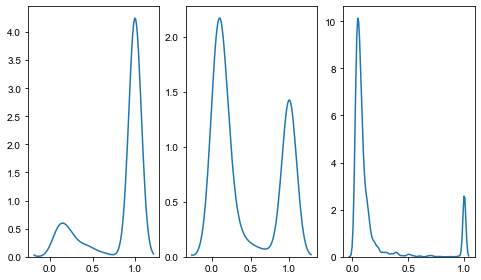

In [6]:
# Check if the outcomes of reliability without ploicies are normally distributed

fig, ax = plt.subplots(1,3)
sns.kdeplot(no_policy_reliability, ax = ax[0])
sns.kdeplot(small_release_reliability, ax = ax[1])
sns.kdeplot(large_release_reliability, ax = ax[2])
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()


The results of the reliability outcomes look like mixtures of two gaussian distributions. To perform a SOBOL analysis, the distribution of the outcomes need to be normally distributed.

In [7]:
problem = get_SALib_problem(lake_model.uncertainties)

Si_no_policy = sobol.analyze(problem, no_policy_reliability,
                       calc_second_order=True, print_to_console=False)

Si_small_release = sobol.analyze(problem, small_release_reliability,
                       calc_second_order=True, print_to_console=False)

Si_large_release = sobol.analyze(problem, large_release_reliability,
                       calc_second_order=True, print_to_console=False)

#### No Policy

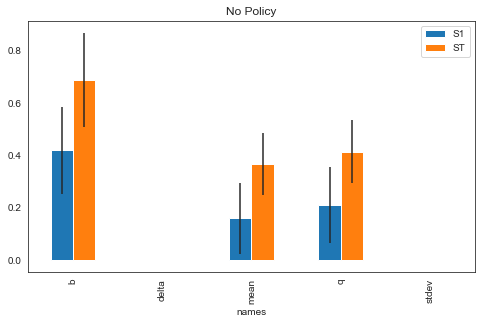

In [8]:

scores_filtered_no_policy = {k:Si_no_policy[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_no_policy_plot = pd.DataFrame(scores_filtered_no_policy)

Si_no_policy_plot["names"] = problem["names"]
Si_no_policy_plot = Si_no_policy_plot.set_index("names")

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_no_policy_plot[['S1','ST']]
err = Si_no_policy_plot[['S1_conf','ST_conf']]

ax.set_title("No Policy")

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [9]:
Si_no_policy_plot

,ST,ST_conf,S1,S1_conf
names,,,,
b,0.689034,0.181173,0.420236,0.166776
delta,0.000008,0.000009,0.000541,0.000804
mean,0.368178,0.118005,0.159070,0.136864
q,0.415104,0.120005,0.210524,0.145774
stdev,0.000031,0.000042,0.000044,0.000879


##### Interpretation

It can be concluded from this first SOBOL analysis that without any policy, feature 'b', the lake natural removal rate, has the largest impact on the reliability of the outcome, both when are interaction effects considered (ST) as when they are not (S1). This can be partly explained by the fact that inertia is the variable that measures whether the pollution of the lake is below the critical treshold, and this crititcal treshold is dependent of the natural removal rate of the lake. The features 'delta' and 'stdev' do not seem to have a big impact on the variation in the outcome of reliability. For delta this makes sense, since this is the discounted benefit of pollution and this feature only affects the economic benefits of the pollution. 

#### Small release policy

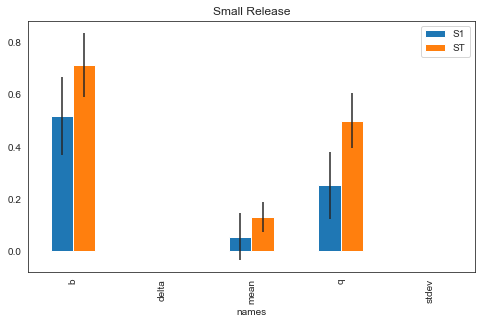

In [10]:
scores_filtered_small_release = {k:Si_small_release[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_small_release_plot = pd.DataFrame(scores_filtered_small_release)

Si_small_release_plot["names"] = problem["names"]
Si_small_release_plot = Si_small_release_plot.set_index("names")

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_small_release_plot[['S1','ST']]
err = Si_small_release_plot[['S1_conf','ST_conf']]

ax.set_title("Small Release")

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [22]:
Si_small_release_plot

,ST,ST_conf,S1,S1_conf
names,,,,
b,0.715481,0.124106,0.517721,0.149481
delta,0.000035,0.000050,0.000321,0.001481
mean,0.130575,0.058325,0.055262,0.090526
q,0.500884,0.105761,0.252149,0.129192
stdev,0.000069,0.000110,-0.000183,0.001089


#### Large release policy

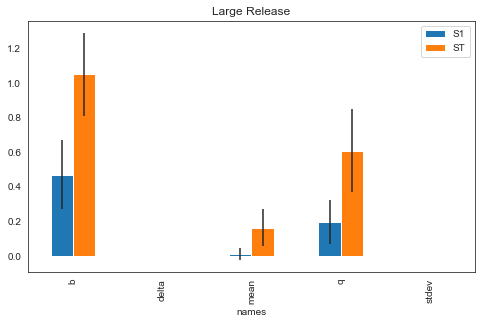

In [12]:
scores_filtered_large_release = {k:Si_large_release[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_large_release_plot = pd.DataFrame(scores_filtered_large_release)

Si_large_release_plot["names"] = problem["names"]
Si_large_release_plot = Si_large_release_plot.set_index("names")

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_large_release_plot[['S1','ST']]
err = Si_large_release_plot[['S1_conf','ST_conf']]

ax.set_title("Large Release")

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [13]:
Si_large_release

{'S1': array([ 4.69656460e-01, -3.84718948e-05,  9.46823644e-03,  1.96691655e-01,
         2.05076214e-04]),
 'S1_conf': array([1.98580371e-01, 1.58575020e-04, 3.40667756e-02, 1.24374601e-01,
        4.02157058e-04]),
 'ST': array([1.04943062e+00, 3.01486265e-06, 1.64845477e-01, 6.09354229e-01,
        8.50372838e-06]),
 'ST_conf': array([2.42679507e-01, 2.93141955e-06, 1.05983456e-01, 2.39577055e-01,
        8.13355905e-06]),
 'S2': array([[            nan,  2.06364584e-01,  2.47261166e-01,
          4.11239948e-01,  2.05975125e-01],
        [            nan,             nan,  3.57747296e-04,
          6.82556771e-04,  3.13659005e-04],
        [            nan,             nan,             nan,
          1.06246961e-01,  1.50293626e-02],
        [            nan,             nan,             nan,
                     nan, -9.11038932e-02],
        [            nan,             nan,             nan,
                     nan,             nan]]),
 'S2_conf': array([[       nan, 0.4109884

In [14]:
Si_large_release_plot

,ST,ST_conf,S1,S1_conf
names,,,,
b,1.049431,0.242680,0.469656,0.198580
delta,0.000003,0.000003,-0.000038,0.000159
mean,0.164845,0.105983,0.009468,0.034067
q,0.609354,0.239577,0.196692,0.124375
stdev,0.000009,0.000008,0.000205,0.000402


##### Interpretation

The SOBOL analysis with the small and large release policies are quite similar to the one without any policies, except from the fact that the feature q has a larger impact on the variation of the reliability outcome for the models with a release policy. Furthermore, the direct effects on the variation of the reliability outcome of the variable b, are higher with a small release policy than without policies. It is also striking that the SOBOL analysis of the mean does become slightly negative, this is probably because the outcomes of the small release policy are not perfectly unimodely distributed. A problem that could be solved by taking a larger sample size. 

## Part 2. Extra Trees Feature Scoring
Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

In [15]:
n_scenarios = 100

trees_results = perform_experiments(lake_model, n_scenarios, policies=policies)
trees_experiments, trees_outcomes = trees_results

[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 210 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 270 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] experiments finished


In [16]:
trees_experiments

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.213592,0.930838,0.049886,2.386507,0.004141,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2400,no policy,lakeproblem
1,0.288996,0.951365,0.036234,3.225027,0.003331,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2401,no policy,lakeproblem
2,0.341761,0.979227,0.010973,2.621930,0.004896,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2402,no policy,lakeproblem
3,0.257814,0.939207,0.046929,3.614986,0.003972,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2403,no policy,lakeproblem
4,0.303161,0.986468,0.018008,3.112002,0.003089,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2404,no policy,lakeproblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.118023,0.967252,0.032742,3.559117,0.004437,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,2495,large release,lakeproblem
296,0.449164,0.955182,0.020612,2.767402,0.003052,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,2496,large release,lakeproblem
297,0.331360,0.958168,0.032225,2.316593,0.004320,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,2497,large release,lakeproblem
298,0.166403,0.948486,0.037912,3.455153,0.002974,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,2498,large release,lakeproblem


In [17]:
# Create subsets of the trees outcomes per policy
trees_no_policy_outcomes = dict()
trees_small_release_outcomes = dict()
trees_large_release_outcomes = dict()

for sub in trees_outcomes: 
    # slicing and reassigning
    trees_no_policy_outcomes[sub] = trees_outcomes[sub][0:100]
    trees_small_release_outcomes[sub] = trees_outcomes[sub][100:200]
    trees_large_release_outcomes[sub] = trees_outcomes[sub][200:300]

In [18]:
uncertainties_experiments = trees_experiments[["b", "delta", "mean", "q", "stdev"]]

In [34]:
trees_large_release_outcomes['inertia']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### No Policy

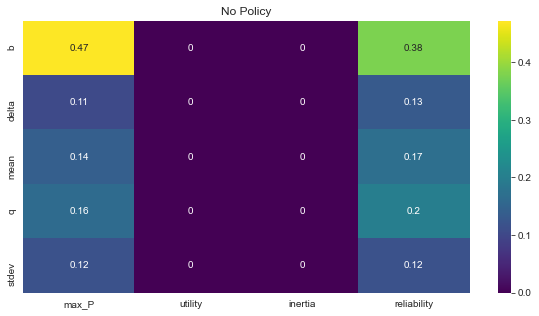

In [29]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

x_no_policy = uncertainties_experiments[0:100]
y_no_policy = trees_no_policy_outcomes

fs = feature_scoring.get_feature_scores_all(x_no_policy, y_no_policy, alg='extra trees', nr_trees=110, max_features=2,mode=RuleInductionType.REGRESSION)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title("No Policy")

sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)

plt.show()

#### Small release policy

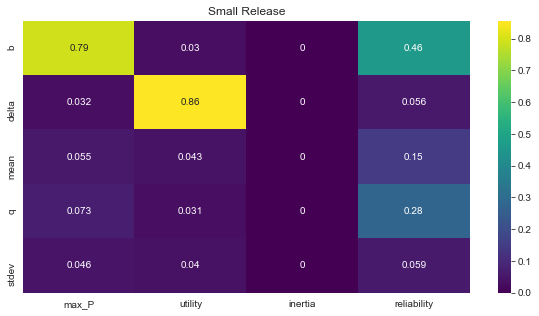

In [20]:
x_small_release = uncertainties_experiments[100:200]
y_small_release = trees_small_release_outcomes

fs = feature_scoring.get_feature_scores_all(x_small_release, y_small_release, alg='extra trees', nr_trees=110, max_features=0.6,mode=RuleInductionType.REGRESSION)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title("Small Release")

sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)

plt.show()

#### Large release policy

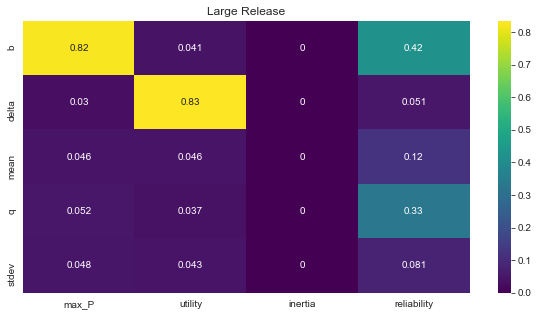

In [21]:
x_large_release = uncertainties_experiments[200:300]
y_large_release = trees_large_release_outcomes

fs = feature_scoring.get_feature_scores_all(x_large_release, y_large_release, alg='extra trees', nr_trees=110, max_features=0.6,mode=RuleInductionType.REGRESSION)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title("Large Release")

sns.heatmap(fs, cmap='viridis', annot=True, ax=ax)

plt.show()

##### Interpretation

In the first heatmap it is immediately string that the variation of the output variables 'utility' and 'inertia' are not at all affected by variation in the model input. This can be easily explained, since the utility and the inertia are drect functions of the antropological pollution, which is zero by default whenever there are no policies specified. The inertia stays zero for the different polcies, which means that even with a release policy of 0.1, the fraction of years where the absolute value of the change in anthropogenic pollution is larger then the treshold is still zero. The utility does increase as the antropogenic release increases. 

The feature ranking for the reliability is similar for the SOBOL analysis as for the Extra trees, regardless of the policy. Although the extra trees does count a minor impact of the delta and stdev variables, while these cannot be distinguished in the sobol analysis.